Import des bibliothèques Python

In [28]:
!pip install scikit-survival

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

from sklearn import set_config
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sksurv.datasets import load_breast_cancer
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

set_config(display="text")  # displays text representation of estimators

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas
import seaborn as sns
from sklearn import set_config
from sklearn.model_selection import GridSearchCV, ShuffleSplit

from sksurv.column import encode_categorical
from sksurv.datasets import load_veterans_lung_cancer
from sksurv.metrics import concordance_index_censored
from sksurv.svm import FastSurvivalSVM

set_config(display="text")  # displays text representation of estimators
sns.set_style("whitegrid")

In [31]:
from sklearn.model_selection import train_test_split

Définition des fonctions

Import des datasets

In [32]:
clinical_train = pd.read_csv('clinical_train.csv')
molecular_train = pd.read_csv('molecular_train.csv')
target_train = pd.read_csv('target_train.csv')

In [33]:
target_train[target_train['OS_YEARS']<=0]

,ID,OS_YEARS,OS_STATUS
41,P106049,0.0,0.0
137,P117409,0.0,0.0
146,P117419,0.0,0.0
178,P117457,0.0,0.0
655,P105840,0.0,0.0
664,P105850,0.0,0.0
687,P105880,0.0,0.0
710,P105910,0.0,0.0
713,P105913,0.0,0.0
716,P105916,0.0,0.0


Preprocessing des bases de données

In [34]:
clinical_train_NaNfree = clinical_train.dropna()
target_train_NaNfree = target_train.dropna()

In [35]:
df_common = pd.merge(clinical_train_NaNfree, target_train_NaNfree, on="ID", how="inner")

In [36]:
df_common

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS,OS_YEARS,OS_STATUS
0,P132697,MSK,14.0,2.80,0.20,0.70,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]",1.115068,1.0
1,P132698,MSK,1.0,7.40,2.40,0.10,11.6,42.0,"46,xx",4.928767,0.0
2,P116889,MSK,15.0,3.70,2.10,0.10,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]",2.043836,0.0
3,P132699,MSK,1.0,3.90,1.90,0.10,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]",2.476712,1.0
4,P132700,MSK,6.0,128.00,9.70,0.90,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]",3.145205,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2451,P121826,VU,1.0,2.50,1.02,0.20,10.2,78.0,"47~49,xy,+21,+21,+22[cp11]/46,xy[10]",0.547945,0.0
2452,P121827,VU,1.5,8.10,2.66,0.45,11.3,40.0,"44,xx,inv(2)(p25q31),-4,del(5)(q12q33),-18[20]",2.339726,0.0
2453,P121830,VU,0.0,1.80,0.55,0.29,9.4,86.0,"46,xy,del(20)(q11.2q13.1)[4]/45,xy,idem,-7[16]",1.997260,0.0
2454,P121853,VU,5.0,1.37,0.37,0.11,11.4,102.0,"46,xx,del(1)(p34)[5]/45,xx,sl,-18[12]/46,xx,sd...",0.095890,1.0


In [40]:
# Extraire la colonne et la convertir en DataFrame (pas une Series)
X = df_common[["CYTOGENETICS"]]

# S'assurer que la colonne est bien de type 'category' ou 'object'
X["CYTOGENETICS"] = X["CYTOGENETICS"].astype("category")

# Appliquer l'encodage
clinical_train_NaNfree_cytogenetics_encoded = OneHotEncoder().fit_transform(X)

y = df_common[['OS_YEARS', 'OS_STATUS']]

/tmp/ipykernel_50747/4255455327.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["CYTOGENETICS"] = X["CYTOGENETICS"].astype("category")


In [41]:
X_train, X_test, y_train, y_test = train_test_split(clinical_train_NaNfree_cytogenetics_encoded, y, test_size=0.25, random_state=0)

In [42]:
X_train

,"CYTOGENETICS=39-44,x,-y,der(5)t(5;17)(q12;q12),der(7)t(5;7)(q23;q21),-12,der(16;20)(p10;p10),-18,dmin[11]/46,xy[4]","CYTOGENETICS=39~46,xy,del(1)(q21),-2,add(3)(p26),del(5q13q31),der(20)t(2;20)(q11.2;q11.2),+1~mar,inc[cp5]/46,xy[2]","CYTOGENETICS=41-45,x,-x,-4,del(5)(q13),-6,add(11)(q24),-15,+r,+2-3mar[cp14]/46,xx[6]","CYTOGENETICS=41-48,xy,del(5)(q11),+8,dic(9;12)(p23;p13),-18,-20,-22,add(22)(q13).+mar1x3cp20","CYTOGENETICS=41~44,x,-x,-7,add(11)(q13),-13,add(15)(p11),-16,add(19)(q13),-21,+1-3mar,1~2dmin[cp8]/42~43,xx,idem,-11,-add(11)[6]/43~44,xx,idem,-add(15),add(15)(p11)[3]/43~44,xx,idem,-15,-add(15)[3]/46,xx[3]","CYTOGENETICS=41~46,xx,del(5)(q14q34),-7,der(7;15)(p10;q10),+8,-9,add(13)(p11.2),-18,-20,-21,+1-2mar[cp17]/46,xx[3]","CYTOGENETICS=42,x,der(y)t(y;1)(q12;q12),del(5)(q12q33),-17,-18,-21,-22[17]/42,xx,idem,-17,+mar[2]/46,xx[1]","CYTOGENETICS=42,xy,der(5),-7,+8,der(9)t(9;12)(q22;q13),-12,add(14)(p11),add(15)(p11)*2,-16,der(19),-21[19]","CYTOGENETICS=42-43,xy,der(4)t(4;12)(q32;q12)del(12)(q14q22),del(5)(q12q35),-7,-12,-13,-14,-16,-17,del(17)(p11),ins(18;7)(q22;?),der(19)t(7;19)(?;13),der(20)t(16;20)(?;q12)t(7;16)(p14;?),-22,ider(22)(q10)t(6;22)(?;q13)t(6;22)(q22;q13),+mar[24]/46,xy[2]","CYTOGENETICS=42-45,xy,-2,-5,-6,-9,add(13)(p11.1),add(14)(p11.1),add(15)(p11.1),-16,-18,-20,del(20)(q11.2)+3-6mar[cp23]/46,xy[1]",...,CYTOGENETICS=del(20q),CYTOGENETICS=del(5q),CYTOGENETICS=del11q,CYTOGENETICS=del20,CYTOGENETICS=del5q,CYTOGENETICS=del5q-,CYTOGENETICS=del7,CYTOGENETICS=dely,"CYTOGENETICS=keinezelleninteilung,cd34pbfish:49%5q-",CYTOGENETICS=tris8
1450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
674,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1731,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


SVM

In [43]:
y_train

,OS_YEARS,OS_STATUS
1450,0.197260,1.0
1666,0.690411,0.0
485,2.304110,0.0
233,0.375342,1.0
674,1.164384,1.0
...,...,...
1033,1.638356,1.0
1731,1.128767,1.0
763,0.991781,0.0
835,1.504110,0.0


In [44]:
import sys

#y_train_bool[y_train_bool['OS_YEARS']<=0]
y_train.loc[y_train['OS_YEARS'] <= 0, 'OS_YEARS'] = 0.000001

In [45]:
# Pour l'histogramme
y_train_bool = y_train.copy()
y_train_bool["OS_STATUS"] = y_train_bool["OS_STATUS"].astype(bool)

In [46]:
n_censored = y_train_bool.shape[0] - y_train_bool["OS_STATUS"].sum()
print(f"{n_censored / y_train_bool.shape[0] * 100:.1f}% of records are censored")

51.5% of records are censored


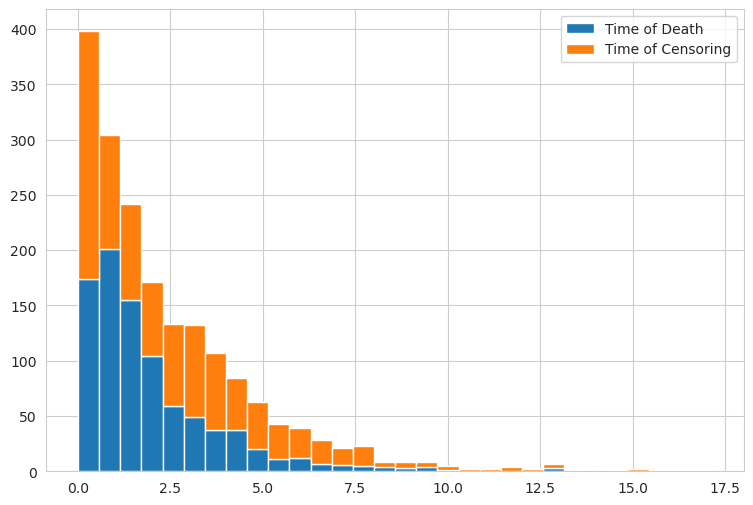

In [47]:
plt.figure(figsize=(9, 6))
val, bins, patches = plt.hist(
    [y_train_bool["OS_YEARS"][y_train_bool["OS_STATUS"] == 1], 
     y_train_bool["OS_YEARS"][y_train_bool["OS_STATUS"] == 0]], 
    bins=30, stacked=True
)
_ = plt.legend(patches, ["Time of Death", "Time of Censoring"])

In [48]:
estimator = FastSurvivalSVM(max_iter=1000, tol=1e-5, random_state=0)

In [49]:
def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y["Status"], y["Survival_in_days"], prediction)
    return result[0]

GridSearch 

In [50]:
param_grid = {"alpha": [2.0**v for v in range(-12, 13, 2)]}
cv = ShuffleSplit(n_splits=100, test_size=0.5, random_state=0)
gcv = GridSearchCV(estimator, param_grid, scoring=score_survival_model, n_jobs=1, refit=False, cv=cv)

In [51]:
from sksurv.util import Surv

# Pour l'histogramme
y_train_bool = y_train.copy()
y_train_bool["OS_STATUS"] = y_train_bool["OS_STATUS"].astype(bool)

y_train_bool = Surv.from_arrays(event=y_train_bool["OS_STATUS"], time=y_train_bool["OS_YEARS"])

In [ ]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
gcv = gcv.fit(X_train, y_train_bool)

In [ ]:
y_train

In [ ]:
f"{gcv.best_score_:.3f}", gcv.best_params_

In [ ]:
def plot_performance(gcv):
    n_splits = gcv.cv.n_splits
    cv_scores = {"alpha": [], "test_score": [], "split": []}
    order = []
    for i, params in enumerate(gcv.cv_results_["params"]):
        name = f'{params["alpha"]:.5f}'
        order.append(name)
        for j in range(n_splits):
            vs = gcv.cv_results_[f"split{j}_test_score"][i]
            cv_scores["alpha"].append(name)
            cv_scores["test_score"].append(vs)
            cv_scores["split"].append(j)
    df = pandas.DataFrame.from_dict(cv_scores)
    _, ax = plt.subplots(figsize=(11, 6))
    sns.boxplot(x="alpha", y="test_score", hue="alpha", data=df, order=order, ax=ax)
    _, xtext = plt.xticks()
    for t in xtext:
        t.set_rotation("vertical")

In [ ]:
plot_performance(gcv)

In [ ]:
estimator.set_params(**gcv.best_params_)
estimator.fit(x, y)

In [ ]:
pred = estimator.predict(x.iloc[:2])
print(np.round(pred, 3))
print(y[:2])

Regression objectives

In [ ]:
ref_estimator = FastSurvivalSVM(rank_ratio=0.0, max_iter=1000, tol=1e-5, random_state=0)
ref_estimator.fit(x, y)

cindex = concordance_index_censored(
    y["Status"],
    y["Survival_in_days"],
    -ref_estimator.predict(x),  # flip sign to obtain risk scores
)
f"{cindex[0]:.3f}"

In [ ]:
pred = ref_estimator.predict(x.iloc[:2])
print(np.round(pred, 3))

Configuration du modèle SVM de survie

In [ ]:
from sksurv.kernels import clinical_kernel
from sksurv.svm import FastKernelSurvivalSVM

kernel_matrix = clinical_kernel(data_x)

In [ ]:
kssvm = FastKernelSurvivalSVM(optimizer="rbtree", kernel="precomputed", random_state=0)

kgcv = GridSearchCV(kssvm, param_grid, scoring=score_survival_model, n_jobs=1, refit=False, cv=cv)

In [ ]:
kgcv = kgcv.fit(kernel_matrix, y)

In [ ]:
f"{kgcv.best_score_:.3f}", kgcv.best_params_

In [ ]:
plot_performance(kgcv)